In [2]:
from pathlib import Path 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from collections import OrderedDict
import sys
import os
import seaborn as sns
import researchpy as rp
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.ticker as ticker

#sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import rr, prep, var_dict, plot

%load_ext autoreload
%autoreload 2

In [157]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived = '/Users/alina/Desktop/MIT/code/data/output/derived_data'
save_path = None # '/Users/alina/Desktop/MIT/code/data/output/figures/comp_vars'

In [4]:
baseline_var = ['src_subject_id', 'interview_date', 'interview_age', 'sex', 'site', 'days_baseline']
dtypes_baseline = { 'src_subject_id' : 'str',
                    'interview_date': 'str' , 
                    'interview_age' : 'int64' ,
                    'sex' : 'str', 
                    'site' : 'int64' ,
                    'days_baseline':  'int64',
                    'version_form': 'str'}

version_form = ['version_form']
treat_group_file = 'treatment_groups.csv'
trt_names = pd.read_csv(Path(data_derived, treat_group_file))

qsts =['snap', 'ssrs'] #, 'masc', 'pc']


In [15]:
#snap

excellent_resp_var = ['snaxrsp'] # SNAP Adolescent Excellent Responder Score ]

inattention_vars_x = [
                    #'snap_inattn_avg', # Average of inattention items -- EXCLUDED [999]
                    'snainatx', #Inattention (mean score) 
                    ] 
inattention_vars_t = [#'snap_inattn_totalscore', # Sum of inattention items',-- EXCLUDED [999]
                      "snainatt"]# Inattention (total score) 

#similar 
hyperact_vars_x = ["snahypax",# Hyperactivity (mean score) 
                    #'snap_hyp_avg',#Average of hyperactivity/impulsivity items - EXCLUDED [999]
                    'snahix'] #Hyperactive/Impulsive (mean score)


                

hyperact_vars_t =["snahypat", #Hyperactivity (total score) ]'snap_hyp_totalscore',# Sum of hyperactivity/impulsivity items 
                  'snahit']# Hyperactive/Impulsive (total score) ]

odd_vars = ['snaoddx', # ODD (mean score) 
            'snaoddt' ]# ODD (total score) ]

snap_vars_list =  np.concatenate((excellent_resp_var, inattention_vars_x, inattention_vars_t, hyperact_vars_x,hyperact_vars_t, odd_vars))
snap_vars_dict = dict(zip(["ex_resp", "inatt_x", "inatt_t" , "hyp_x", "hyp_t", "odd"], [ excellent_resp_var, inattention_vars_x, inattention_vars_t , hyperact_vars_x, hyperact_vars_t,  odd_vars ]))
#ssrs
ss_vars = ['sspsconx' ,#Social Conduct raw score 
            'ssptossx'] #Total social skills mean score ]

int_vars = ['sspintx']# Internalizing behavior mean score ]
ssrs_vars_list = np.concatenate((ss_vars, int_vars))
ssrs_vars_dict = dict(zip(["ss", "int"], [ss_vars, int_vars]))


################# MEDIATORS ##################

comorb_anx_diags1_vars = ['pso' ,# Social phobia 
'psoi', # Social phobia with impairment 
'pag', # Agoraphobia 
'pagi' , #Agoraphobia with impairment 
'ppa', # Panic disorder 
'ppai', # Panic disorder with impairment 
'pga', # Generalized anxiety disorder (
'pgai', # Generalized anxiety disorder with impairment 
'poa', # Overanxious disorder 
'poai'] #Overanxious disorder with impairment ]

comorb_anx_diags5_vars = ['ag4crt', #AGORAPHOBIA. 
'pd4crt', # PANIC DISORDER. 
'agn4crt', # AGORAPHOBIA. 
#'sp4crt', # SPECIFIC PHOBIA. 
'so4crt', # SOCIAL PHOBIA. 
'ga4crt'# GENERALIZED ANXIETY DISORDER. 
]
                   

qsts_vars_dict = dict(zip(qsts, [snap_vars_dict, ssrs_vars_dict]))
vars_dict = { **snap_vars_dict, **ssrs_vars_dict}


In [126]:
hyperact_vars_x

['snahypax', 'snahix']

In [127]:
outcomes = np.concatenate((hyperact_vars_x, ssrs_vars_list))


#outcome variables 
outcomes_written = ['SNAP Hyperactivity', 'SNAP Hyperactivity-Impulsivity',
                    'SSRS Social Conduct raw score', 'SSRS Social Skills']
outcomes_dict_fig = dict(zip(outcomes, outcomes_written))
outcomes_dict_fig

{'snahypax': 'SNAP Hyperactivity',
 'snahix': 'SNAP Hyperactivity-Impulsivity',
 'sspsconx': 'SSRS Social Conduct raw score',
 'ssptossx': 'SSRS Social Skills'}

In [6]:

snap_file = 'snap01.txt'
ssrs_file = 'ssrs01.txt'
masc_file = 'masc_p01.txt'
parent_child_file = 'pcrc01.txt'
wechsler_file = 'wiat_iiip201.txt'
treat_group_file = 'treatment_groups.csv'

######################




In [72]:
snap = prep.get_data(Path(data_root, snap_file), treat_group= trt_names,  columns=[baseline_var, snap_vars_list], version_form=True, set_dtypes=True)
ssrs = prep.get_data(Path(data_root, ssrs_file), treat_group= trt_names,  columns=[baseline_var, ssrs_vars_list], version_form=True, set_dtypes=True)
#masc = pd.read_csv(Path(data_root, masc_file), delimiter='\t')
#pc = pd.read_csv(Path(data_root, parent_child_file), delimiter='\t')
#wechsler = pd.read_csv(Path(data_root, wechsler_file), delimiter='\t')

anx_diags1 = prep.get_data(Path(data_root, 'diagpsx01.txt'), columns=[baseline_var, comorb_anx_diags1_vars], treat_group=trt_names, set_dtypes=True, split_timepoints=False)
#anx_diags5 = prep.get_data(Path(data_root, 'diagpsx_p501.txt'), columns=[baseline_var, comorb_anx_diags5_vars], treat_group=trt_names, set_dtypes=True, split_timepoints=False)

data_dict = dict(zip(['snap', 'ssrs'], [snap, ssrs]) )#, masc, pc]))

Success
Success
Success
Success


/Users/alina/Desktop/MIT/code/ADHD/MTA/helper/prep.py:30: DtypeWarning: Columns (22,23,24,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, delimiter="\t", usecols=columns, skiprows=[1] , parse_dates=['interview_date']).dropna(subset='days_baseline').drop_duplicates()


In [80]:
anx_diags5 = pd.read_csv(Path(data_root, 'diagpsx_p501.txt'), usecols=  np.concatenate((baseline_var, comorb_anx_diags5_vars)), delimiter = '\t')

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_11090/601144943.py:1: DtypeWarning: Columns (5,6,8,12,22,23,24,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  anx_diags5 = pd.read_csv(Path(data_root, 'diagpsx_p501.txt'), usecols=  np.concatenate((baseline_var, comorb_anx_diags5_vars)), delimiter = '\t')


In [81]:
prep.print_nonNaN_shapes(anx_diags5)

0 src_subject_id Subject ID how it's defined in lab/project (9704,)
1 interview_date Date on which the interview/genetic test/sampling/imaging/biospecimen was completed. MM/DD/YYYY (6664,)
2 interview_age Age in months at the time of the interview/test/sampling/imaging. (9704,)
3 sex Sex of subject at birth (9704,)
4 days_baseline Days since baseline (9703,)
5 site Site (9503,)
6 ag4crt AGORAPHOBIA. (202,)
7 pd4crt PANIC DISORDER. (202,)
8 agn4crt AGORAPHOBIA. (202,)
9 so4crt SOCIAL PHOBIA. (202,)
10 ga4crt GENERALIZED ANXIETY DISORDER. (202,)


In [8]:
for var in snap_vars_dict.keys():
    print(var)
    for out in snap_vars_dict[var]:
        print(out, data_dict['snap'][snap_vars_dict[var]][out].dropna().shape)
        print(data_dict['snap'][snap_vars_dict[var]][out].unique())

ex_resp
snaxrsp (14392,)
[1. 0.]
inatt_x
snainatx (14392,)
[0.11 0.33 0.   2.   1.   1.11 0.44 0.67 1.78 2.56 2.44 2.67 1.67 1.89
 1.33 1.56 1.44 1.63 1.22 2.38 2.89 2.22 0.78 0.56 0.89 3.   2.33 1.88
 0.22 1.38 0.13 2.11 2.78 2.13 1.57 0.88 0.5  1.43 1.75 2.75 2.5  0.57
 2.25 1.5  0.71 0.75 0.25 0.29 0.63 2.88 1.25 1.13 1.71 0.38 2.63 2.29]
inatt_t
snainatt (14392,)
[ 1.    3.    0.   18.    9.   10.    4.    6.   16.   23.   22.   24.
 15.   17.   12.   14.   13.   14.63 11.   21.38 26.   20.    7.    5.
  8.   27.   21.   16.88  2.   12.38  1.13 19.   25.   19.13 14.14  7.88
  4.5  12.86 15.75 24.75 22.5   5.14 20.25 13.5   6.43  6.75  2.25  2.57
  5.63 25.88 11.25 10.13 15.43  3.38 23.63 20.57]
hyp_x
snahypax (14392,)
[0.   1.17 0.5  1.   0.33 0.17 0.67 3.   2.6  2.83 1.2  1.33 1.6  0.83
 1.83 2.   2.33 1.67 1.5  2.5  2.4  2.17 0.8  2.67 1.8  0.6  0.2  2.2
 1.4  0.4  2.8 ]
snahix (14392,)
[0.22 0.   1.56 0.78 1.   0.44 1.22 0.89 0.56 2.75 2.78 1.5  1.89 1.33
 1.78 2.44 2.11 1.44 0.

In [9]:
varss = "hyp_x"
print(vars_dict[varss])
data_dict['snap'] = data_dict['snap'][data_dict['snap'][vars_dict[varss][0] ]!= 999]



['snahypax', 'snahix']


In [148]:
def compare_vars(data,  varss_list, plot = False, trt_name = None, days_baseline = None, outcomes_dict_fig = None, save_path = None):
    
    if trt_name is not None: 
        data = data[data['trtname'] == trt_name]
        
    if days_baseline is not None:
        data = data[data['days_baseline'] < days_baseline]


    
    data_long = pd.melt(data, id_vars=['src_subject_id', 'days_baseline'], 
                    value_vars = varss_list ,
                    var_name='variable', value_name='value')
    model = smf.mixedlm("value ~ C(variable) * days_baseline", 
                    data_long, 
                    groups=data_long["src_subject_id"])

    result = model.fit()

# Output the summary of the model
    print(result.summary())
    
    if plot : 
        plt.figure(figsize=(15,10))
    sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')

    plt.xlabel('Time (days)')
    plt.ylabel('Value')
    out_names = [outcomes_dict_fig[varr] + ' (' + str(varr) + ') ' for varr in varss_list]
    
    trt_name_dict = { 'M': 'Medication Management', 
                     'P': 'Behavioral Treatment', 
                     'C' : 'Combined Treatment',
                     'A': 'Community Care'
    }
    if trt_name is not None: 
        plt.title('{} and {} \n Treatment Arm {}'.format(out_names[0], out_names[1], trt_name_dict[trt_name]))
        fig_name = 'comp_' + out_names[0] + '_' + out_names[1] + '_' + trt_name + '.png'
    else: 
        plt.title('{} and {} \n All Treatments Combined'.format(out_names[0], out_names[1]))
        fig_name = 'comp_' + out_names[0] + '_' + out_names[1] + '.png'
        
    if save_path is not None: 
        plt.savefig(Path(save_path, fig_name), bbox_inches='tight')
        
    plt.legend(title='Variable')
    plt.show()
        
    return result
    

In [11]:
trt_names_ = ['M', 'P', 'C', 'A']

### check again interpretation of RR results 

                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         value    
No. Observations:          2396            Method:                     REML     
No. Groups:                144             Scale:                      0.0727   
Min. group size:           2               Log-Likelihood:             -431.2771
Max. group size:           30              Converged:                  Yes      
Mean group size:           16.6                                                 
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              0.868    0.019 45.504 0.000  0.830  0.905
C(variable)[T.ssptossx]                0.098    0.017  5.861 0.000  0.065  0.130
days_baseline                          0.001    0.

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_11090/870129826.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


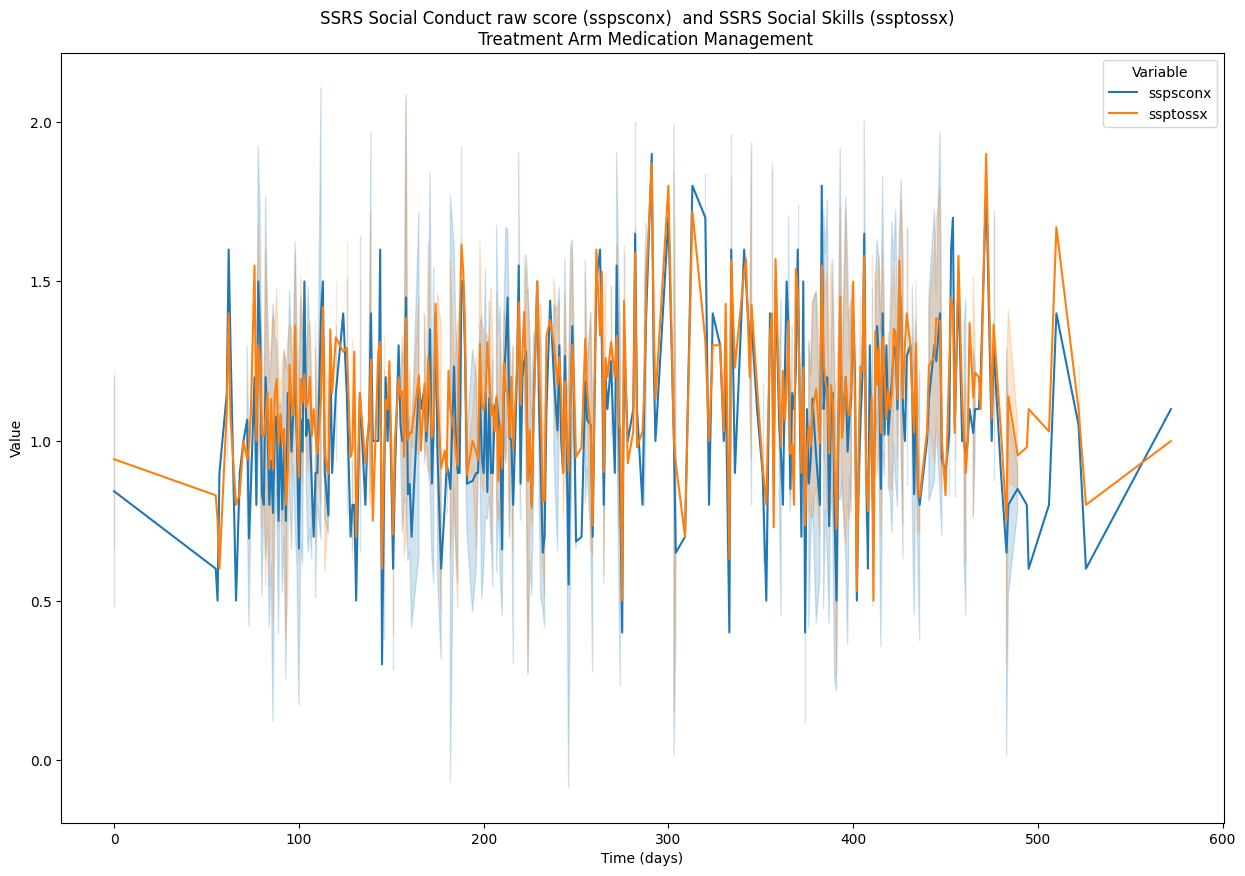

                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         value    
No. Observations:          2468            Method:                     REML     
No. Groups:                144             Scale:                      0.0717   
Min. group size:           2               Log-Likelihood:             -412.5635
Max. group size:           30              Converged:                  Yes      
Mean group size:           17.1                                                 
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              0.891    0.018 50.200 0.000  0.857  0.926
C(variable)[T.ssptossx]                0.075    0.016  4.571 0.000  0.043  0.107
days_baseline                          0.000    0.

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_11090/870129826.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


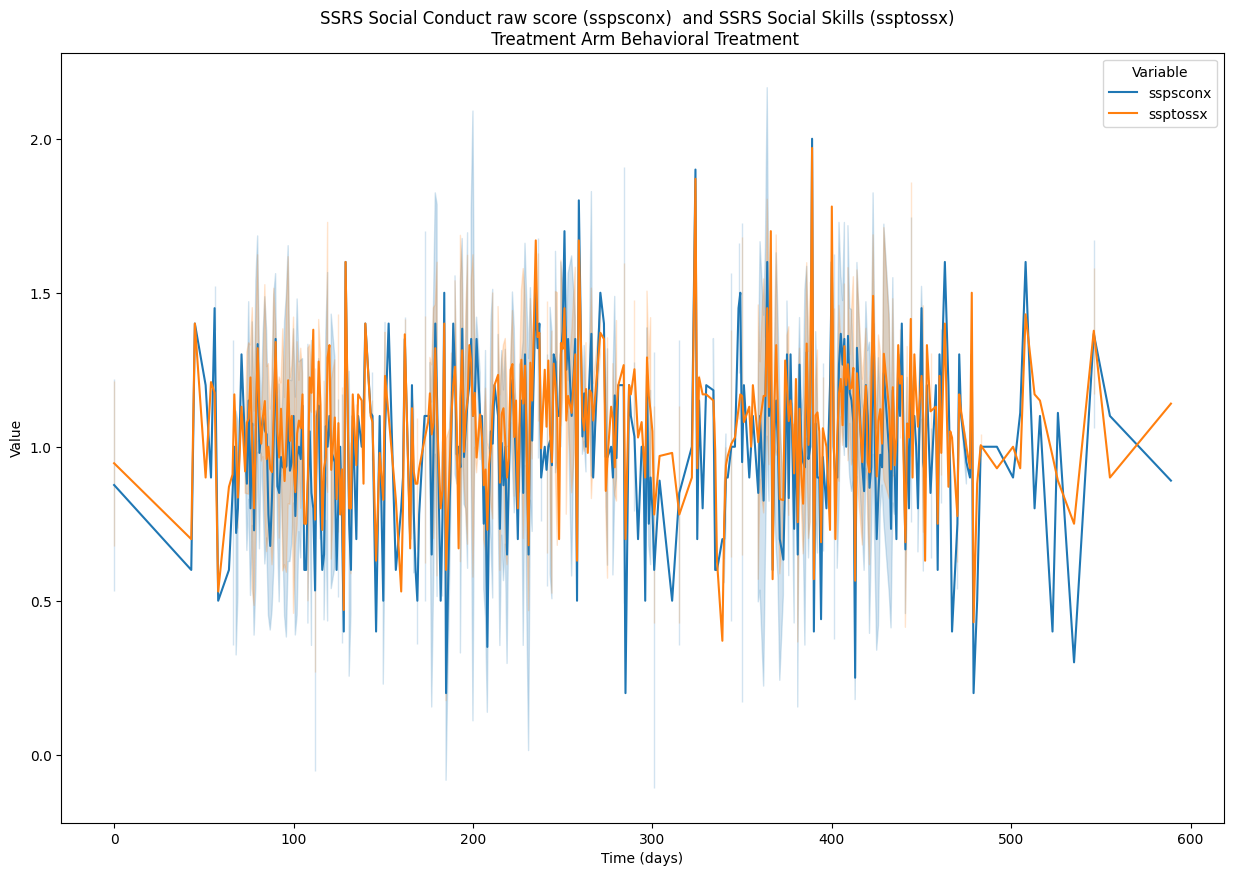

                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         value    
No. Observations:          2540            Method:                     REML     
No. Groups:                145             Scale:                      0.0712   
Min. group size:           4               Log-Likelihood:             -416.9174
Max. group size:           36              Converged:                  Yes      
Mean group size:           17.5                                                 
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              0.945    0.018 52.679 0.000  0.910  0.980
C(variable)[T.ssptossx]                0.073    0.016  4.539 0.000  0.041  0.104
days_baseline                          0.001    0.

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_11090/870129826.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


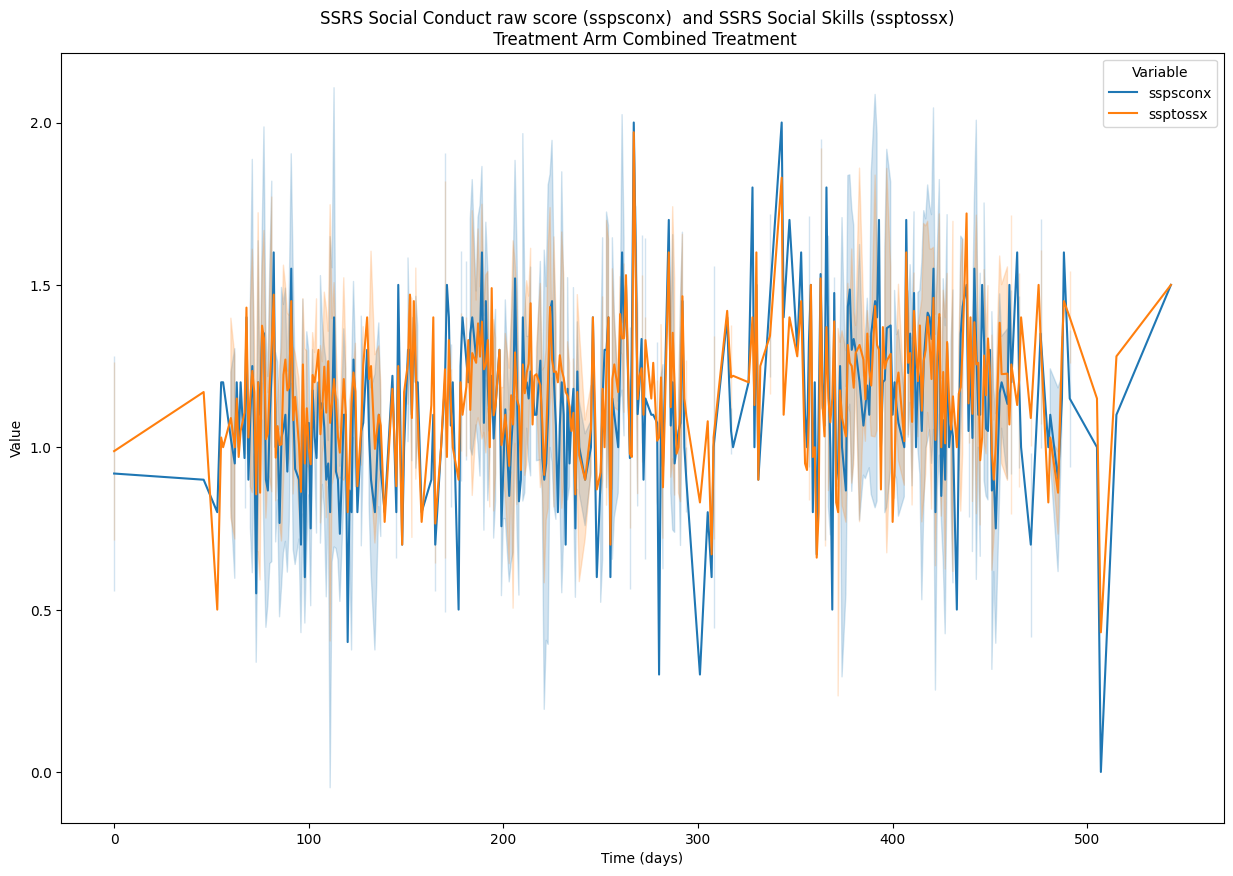

                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         value    
No. Observations:          2454            Method:                     REML     
No. Groups:                146             Scale:                      0.0717   
Min. group size:           4               Log-Likelihood:             -422.9216
Max. group size:           26              Converged:                  Yes      
Mean group size:           16.8                                                 
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              0.886    0.019 47.282 0.000  0.850  0.923
C(variable)[T.ssptossx]                0.103    0.017  6.228 0.000  0.071  0.135
days_baseline                          0.000    0.

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_11090/870129826.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


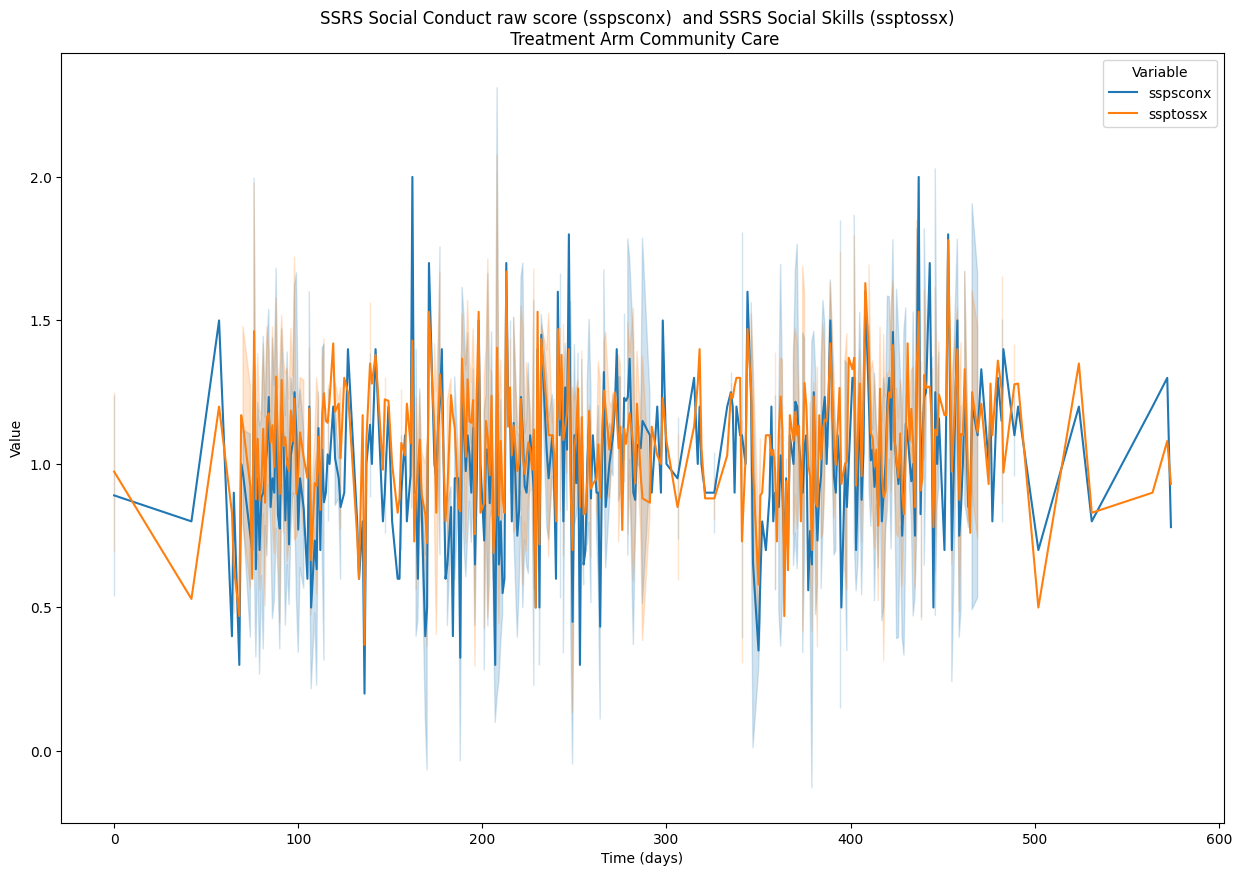

In [149]:
data = data_dict['ssrs']
var = 'ss'
varss = ssrs_vars_dict[var]
for trtname in trt_names_:
    compare_vars(data, varss, plot= True, trt_name= trtname, days_baseline= 600, outcomes_dict_fig= outcomes_dict_fig, save_path= save_path)

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         value     
No. Observations:          12604           Method:                     REML      
No. Groups:                868             Scale:                      0.0726    
Min. group size:           2               Log-Likelihood:             -2462.1982
Max. group size:           36              Converged:                  Yes       
Mean group size:           14.5                                                  
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              1.043    0.010 107.040 0.000  1.024  1.062
C(variable)[T.ssptossx]                0.062    0.007   8.776 0.000  0.048  0.076
days_baseline                         

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_11090/870129826.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


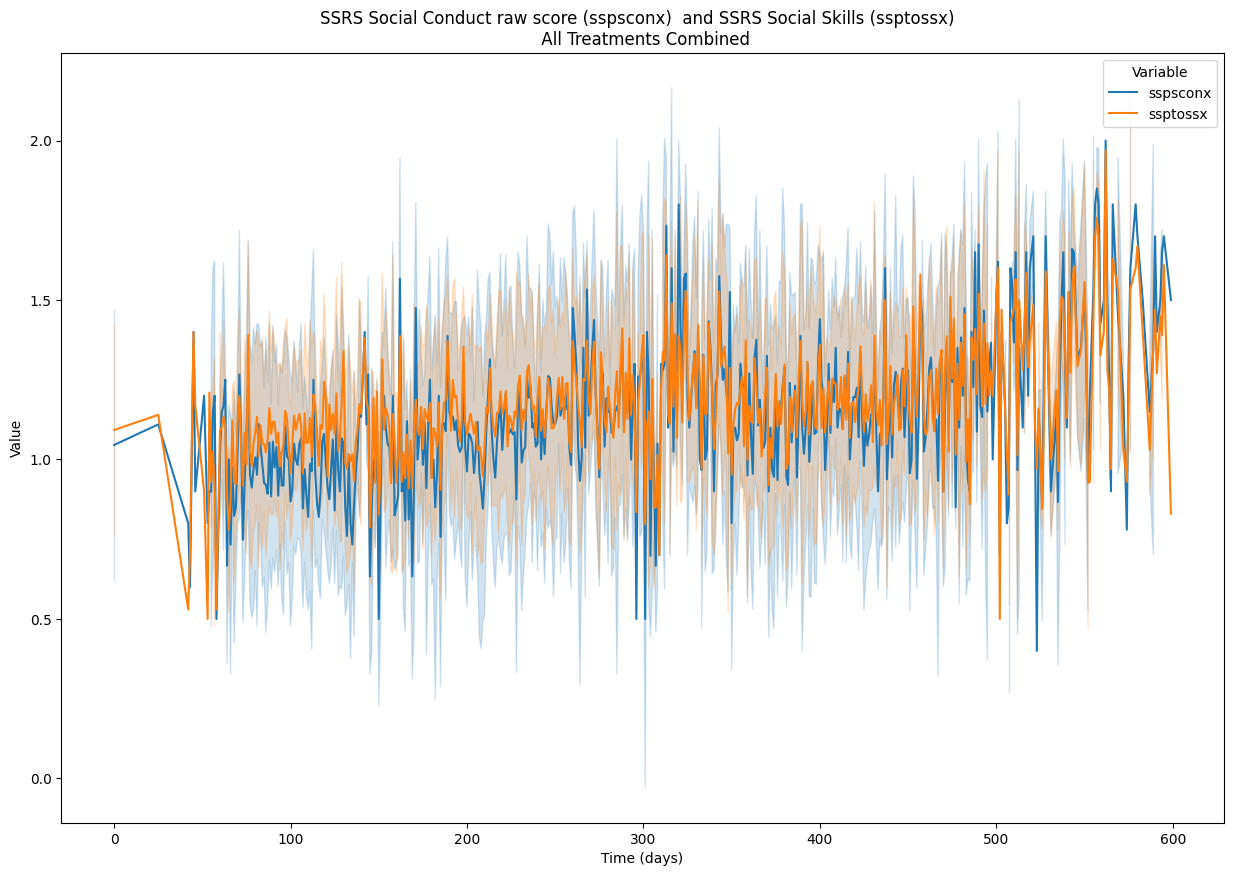

In [152]:
data = data_dict['ssrs']
var = 'ss'
varss = ssrs_vars_dict[var]

compare_vars(data, varss, plot= True, trt_name= None, days_baseline= 600, outcomes_dict_fig= outcomes_dict_fig, save_path= save_path)

In [153]:
data = data_dict['snap']
var = 'hyp_x'
varss = snap_vars_dict[var]
varss

['snahypax', 'snahix']

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         value     
No. Observations:          2948            Method:                     REML      
No. Groups:                144             Scale:                      0.3808    
Min. group size:           6               Log-Likelihood:             -2920.7723
Max. group size:           38              Converged:                  Yes       
Mean group size:           20.5                                                  
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              1.782    0.035  51.039 0.000  1.714  1.851
C(variable)[T.snahypax]               -0.021    0.028  -0.758 0.449 -0.077  0.034
days_baseline                         

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_11090/870129826.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


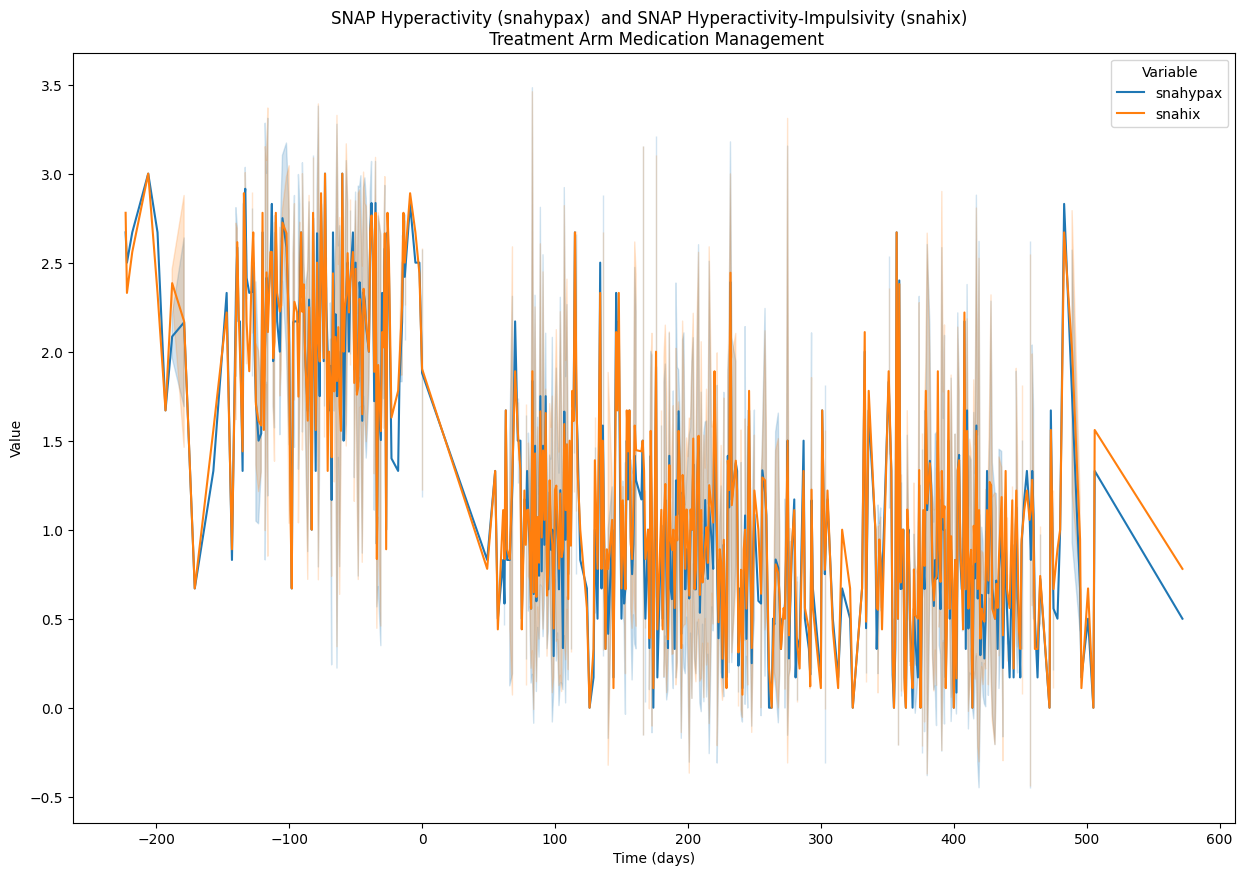

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         value     
No. Observations:          3042            Method:                     REML      
No. Groups:                144             Scale:                      0.3365    
Min. group size:           8               Log-Likelihood:             -2864.0913
Max. group size:           34              Converged:                  Yes       
Mean group size:           21.1                                                  
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              1.858    0.041  44.924 0.000  1.777  1.940
C(variable)[T.snahypax]               -0.007    0.027  -0.273 0.785 -0.059  0.045
days_baseline                         

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_11090/870129826.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


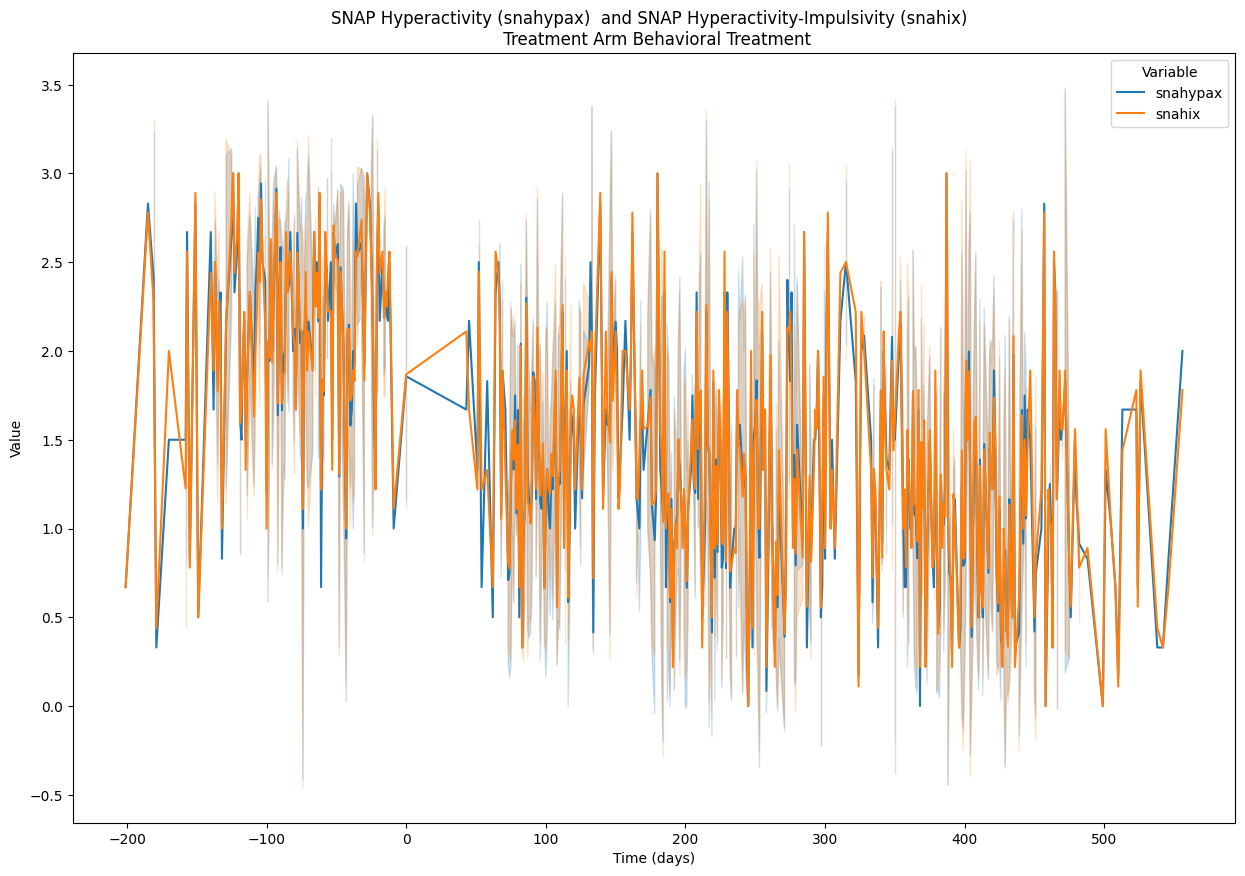

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         value     
No. Observations:          3124            Method:                     REML      
No. Groups:                145             Scale:                      0.3550    
Min. group size:           8               Log-Likelihood:             -2997.4382
Max. group size:           32              Converged:                  Yes       
Mean group size:           21.5                                                  
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              1.669    0.037  45.580 0.000  1.597  1.741
C(variable)[T.snahypax]               -0.020    0.027  -0.729 0.466 -0.072  0.033
days_baseline                         

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_11090/870129826.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


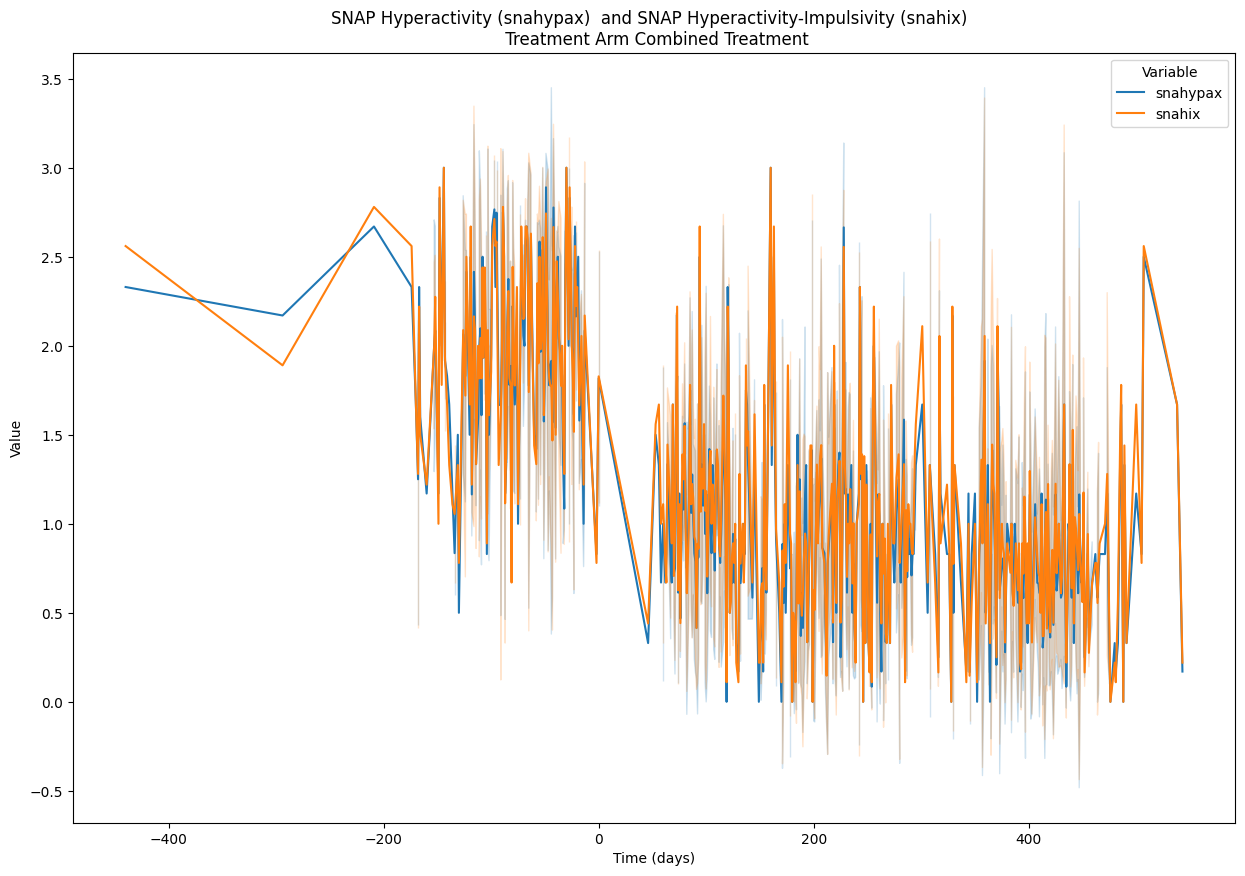

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         value     
No. Observations:          3034            Method:                     REML      
No. Groups:                146             Scale:                      0.3795    
Min. group size:           10              Log-Likelihood:             -3021.6344
Max. group size:           32              Converged:                  Yes       
Mean group size:           20.8                                                  
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              1.866    0.039  47.646 0.000  1.790  1.943
C(variable)[T.snahypax]               -0.026    0.028  -0.921 0.357 -0.082  0.029
days_baseline                         

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_11090/870129826.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


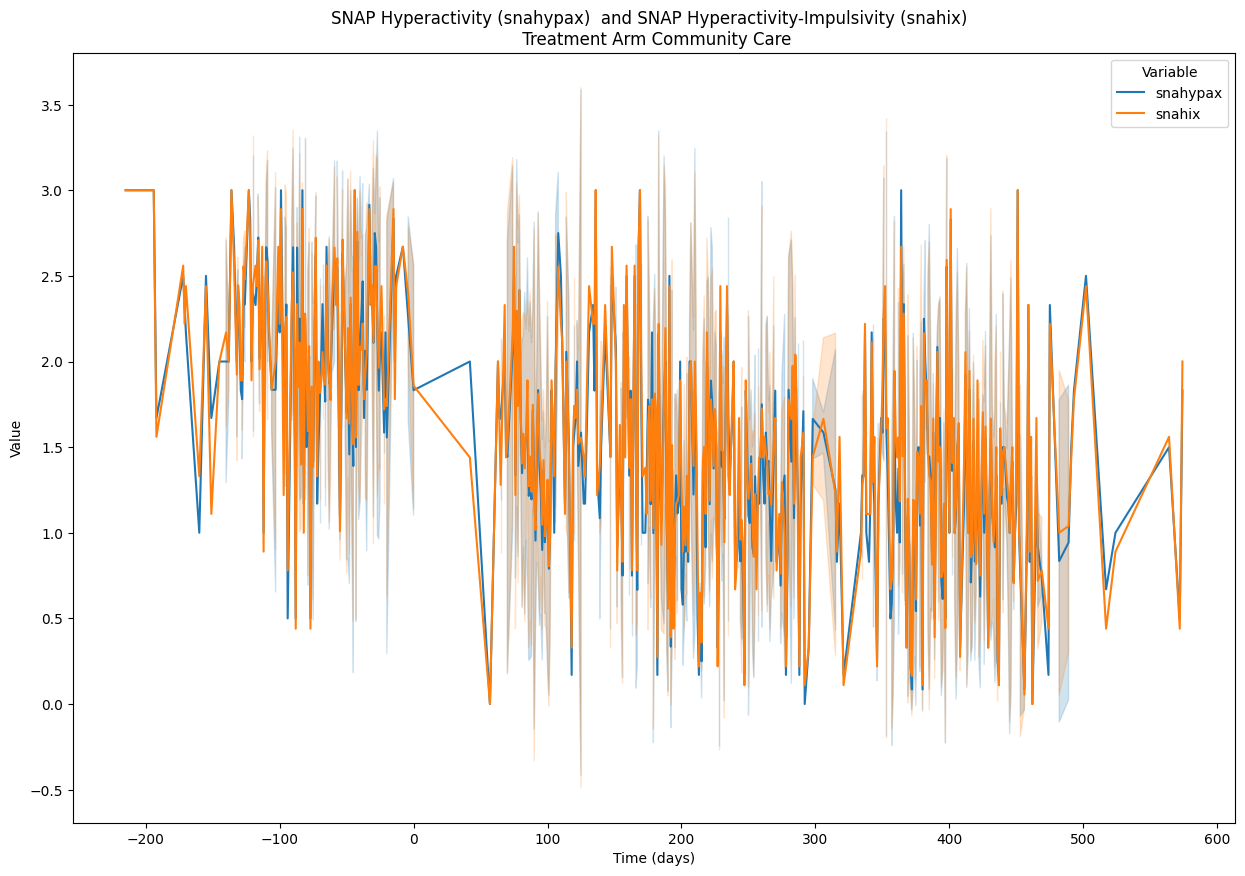

In [155]:

for trtname in trt_names_:

    compare_vars(data, varss, plot= True, trt_name= trtname, days_baseline= 600, outcomes_dict_fig= outcomes_dict_fig, save_path=save_path)


                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         value      
No. Observations:         15060           Method:                     REML       
No. Groups:               868             Scale:                      0.3495     
Min. group size:          2               Log-Likelihood:             -14742.7075
Max. group size:          38              Converged:                  Yes        
Mean group size:          17.4                                                   
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              1.404    0.023  60.982 0.000  1.358  1.449
C(variable)[T.snahypax]               -0.022    0.012  -1.758 0.079 -0.046  0.002
days_baseline                         

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_11090/870129826.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='days_baseline', y='value', hue='variable', data=data_long, ci='sd')


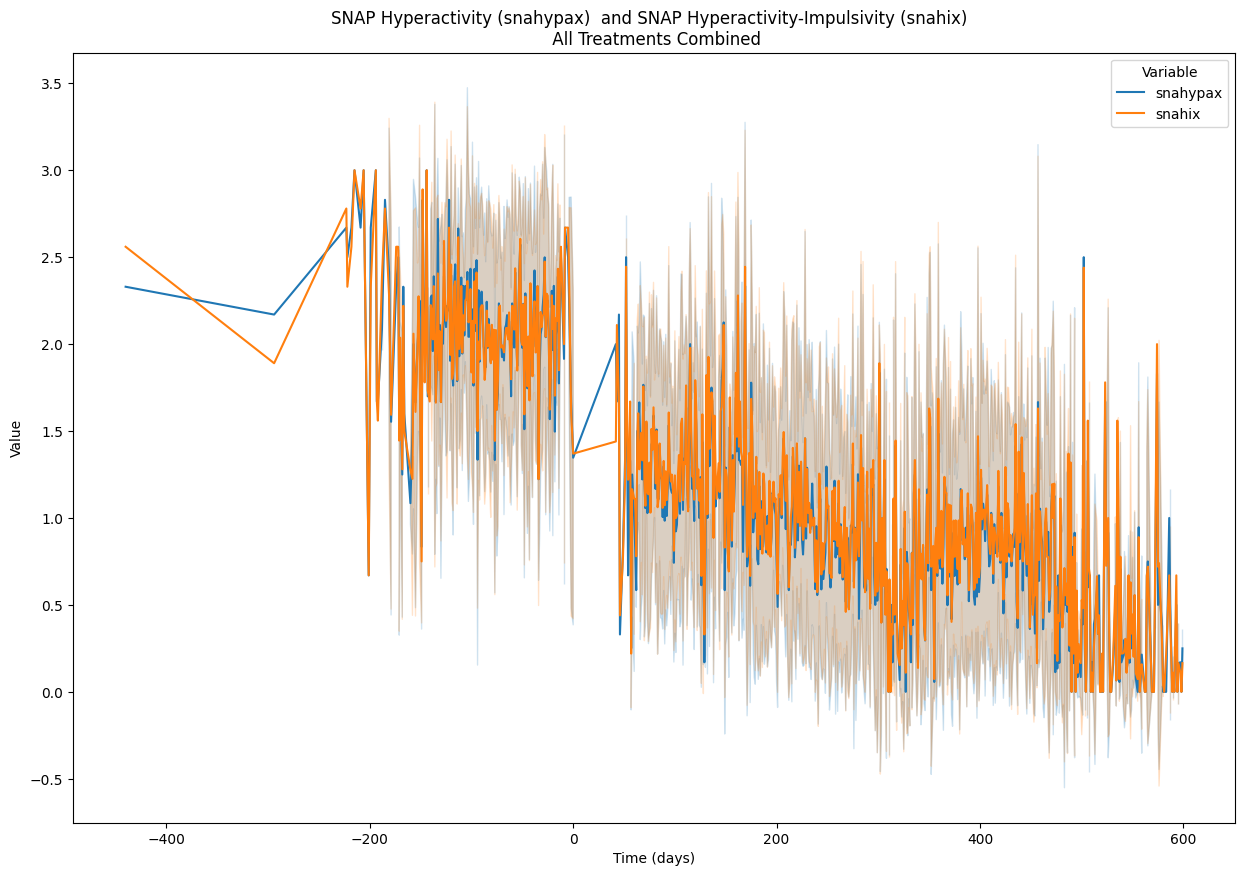

In [156]:
compare_vars(data, varss, plot= True, trt_name= None, days_baseline= 600, outcomes_dict_fig= outcomes_dict_fig, save_path=save_path)

In [142]:
var = 'hyp_x'
snap_vars_dict[var]

['snahypax', 'snap_hyp_avg', 'snahix']

In [143]:
test_lines = [plot.extract_line_plot(data_dict['snap'], snap_vars_dict[var][i], type_plot='mov_av', timepoints= None, window= 50  ) for i in range(len(snap_vars_dict[var]))]


0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (0,) SHAPE subset sorted (0,)
type moving average
SMOOTHED shape (0, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)


In [89]:
qsts_vars_dict['snap']

{'ex_resp': ['snaxrsp'],
 'inatt': ['snap_inattn_totalscore',
  'snap_inattn_avg',
  'snainatx',
  'snainatt'],
 'hyp': ['snahypax', 'snahypat', 'snap_hyp_avg', 'snahix', 'snahit'],
 'odd': ['snaoddx', 'snaoddt']}

In [119]:
def extract_var_lines(data_dict, qsts_vars_dict, type_plot, window, type_return): 
    qsts_lines = {}
    var_lines = {}
    for qst in qsts:
        var_dict = qsts_vars_dict[qst]
        for var in var_dict.keys():
            lines = [plot.extract_line_plot(data_dict[qst], qsts_vars_dict[qst][var][i], type_plot='mov_av', timepoints= None, window= 50  ) for i in range(len(qsts_vars_dict[qst][var]))]
            var_lines[var] = lines
            
        qsts_lines[qst] = var_lines
        
    if type_return == 'var':
        return var_lines
    else: 
        return qsts_lines

In [120]:
var_lines_dict = extract_var_lines(data_dict, qsts_vars_dict, 'mov_av', 50,'var' )

0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (0,) SHAPE subset sorted (0,)
type moving average
SMOOTHED shape (0, 2)
0
SHAPE subset: (0,) SHAPE subset sorted (0,)
type moving average
SMOOTHED shape (0, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (0,) SHAPE subset sorted (0,)
type moving average
SMOOTHED shape (0, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (14392,) SHAPE subset sorted (14392,)
type moving average
SMOOTHED shape (14392, 2)
0
SHAPE subset: (14392,) SHAPE subse

In [121]:
var_lines_dict.keys()

dict_keys(['ex_resp', 'inatt', 'hyp', 'odd', 'ss', 'int'])

In [128]:
def plot_vars(lines,vars_list):
    plt.figure()
    for i in range(len(lines)):
        plt.plot(lines[i]['days_baseline'], lines[i]["smoothed_value"], label = vars_list[i] + " N  = " + str(lines[i].shape[0]))
    plt.legend()
    plt.show()
    

In [130]:
qsts_vars_dict

{'snap': {'ex_resp': ['snaxrsp'],
  'inatt': ['snap_inattn_totalscore',
   'snap_inattn_avg',
   'snainatx',
   'snainatt'],
  'hyp': ['snahypax', 'snahypat', 'snap_hyp_avg', 'snahix', 'snahit'],
  'odd': ['snaoddx', 'snaoddt']},
 'ssrs': {'ss': ['sspsconx', 'ssptossx'], 'int': ['sspintx']}}

In [ ]:
for key, lines in var_lines_dict.items():
    plot_vars(lines, vars_dict[key])

In [ ]:
#diagpsx01.txt
# diagpsx_p401

### plot moving average 

In [63]:
anx_diags1

,src_subject_id,interview_date,interview_age,sex,days_baseline,site,pso,psoi,pag,pagi,ppa,ppai,pga,pgai,poa,poai,trtname
5545,P1001,1997-06-27,156,M,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L
5546,P1001,1998-10-30,172,M,489,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L
5547,P1002,1997-04-29,119,M,-34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C
5548,P1002,1998-08-02,134,M,426,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,C
5549,P1002,1999-04-30,143,M,697,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8210,P1866,1999-11-24,112,F,495,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L
8211,P1867,1998-01-28,96,M,0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L
8212,P1867,1999-05-18,112,M,476,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L
8213,P1868,1998-01-30,96,F,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L


### ANX

In [17]:
comorb_anx_diags1_vars

['pso', 'psoi', 'pag', 'pagi', 'ppa', 'ppai', 'pga', 'pgai', 'poa', 'poai']

In [25]:
anx_diags1

,src_subject_id,interview_date,interview_age,sex,days_baseline,site,pso,psoi,pag,pagi,ppa,ppai,pga,pgai,poa,poai,trtname,anx
5545,P1001,1997-06-27,156,M,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,<NA>
5546,P1001,1998-10-30,172,M,489,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,<NA>
5547,P1002,1997-04-29,119,M,-34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C,<NA>
5548,P1002,1998-08-02,134,M,426,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,C,<NA>
5549,P1002,1999-04-30,143,M,697,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8210,P1866,1999-11-24,112,F,495,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,<NA>
8211,P1867,1998-01-28,96,M,0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,<NA>
8212,P1867,1999-05-18,112,M,476,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,<NA>
8213,P1868,1998-01-30,96,F,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,<NA>


In [83]:
mask_anx1 = (anx_diags1[comorb_anx_diags1_vars] == 1).any(axis=1)  # Adjusted to get True/False values per row
mask_anx0 = (anx_diags1[comorb_anx_diags1_vars] == 0).all(axis=1)  # Adjusted to get True/False values per row
# Initialize the 'anx' column with NA
anx_diags1['anx'] = pd.NA
anx_diags1.loc[mask_anx1, 'anx'] = 1
anx_diags1.loc[mask_anx0, 'anx'] = 0

In [87]:
anx_diags5.dropna(subset=comorb_anx_diags5_vars)

,src_subject_id,interview_date,interview_age,sex,days_baseline,site,ag4crt,pd4crt,agn4crt,so4crt,ga4crt,anx
0,Subject ID how it's defined in lab/project,Date on which the interview/genetic test/sampl...,Age in months at the time of the interview/tes...,Sex of subject at birth,Days since baseline,Site,AGORAPHOBIA.,PANIC DISORDER.,AGORAPHOBIA.,SOCIAL PHOBIA.,GENERALIZED ANXIETY DISORDER.,<NA>
6463,P1001,11/26/2001,209,M,1612,NaN,/ab,d/abc,b/acd,f/abcdegh,/abcdef,<NA>
6464,P1001,11/24/2003,233,M,2340,NaN,/ab,d/abc,b/acd,f/abcdegh,/abcdef,<NA>
6465,P1003,12/11/2004,222,M,3455,NaN,/ab,d/abc,b/acd,f/abcdegh,/abcdef,<NA>
6466,P1003,03/08/2006,236,M,3907,NaN,ab/,cd/ab,bcd/,abdefgh/c,/abcdef,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
6659,P1548,09/02/2008,211,M,3864,NaN,/ab,d/abc,b/acd,f/abcdegh,/abcdef,<NA>
6660,P1574,11/17/2005,211,F,3881,NaN,/ab,d/abc,b/acd,af/bcdegh,/abcdef,<NA>
6661,P1576,09/12/2006,211,M,3864,NaN,/ab,d/abc,b/acd,f/abcdegh,/abcdef,<NA>
6662,P1584,11/05/2005,210,F,3096,NaN,/ab,d/abc,b/acd,f/abcdegh,/abcdef,<NA>


In [88]:
mask_anx1_5 = (anx_diags5[comorb_anx_diags5_vars] == 1).any(axis=1)  # Adjusted to get True/False values per row
mask_anx0_5 = (anx_diags5[comorb_anx_diags5_vars] == 0).all(axis=1)  # Adjusted to get True/False values per row
# Initialize the 'anx' column with NA
anx_diags5['anx'] = pd.NA
anx_diags5.loc[mask_anx1_5, 'anx'] = 1
anx_diags5.loc[mask_anx0_5, 'anx'] = 0

In [89]:
anx_diags5['anx']

0       <NA>
1       <NA>
2       <NA>
3       <NA>
4       <NA>
        ... 
9699    <NA>
9700    <NA>
9701    <NA>
9702    <NA>
9703    <NA>
Name: anx, Length: 9704, dtype: object

In [67]:
anx_diags5['anx']

Series([], Name: anx, dtype: object)

## Public assistance 

In [123]:
assist_file = 'demgr01.txt'
assist_vars = ['demo61']
assist = prep.get_data(Path(data_root, assist_file), columns= [baseline_var, assist_vars], version_form=False, treat_group= trt_names ,set_dtypes=True, split_timepoints=False)

Success


In [124]:
assist.demo61.unique()

array([2., 1.])

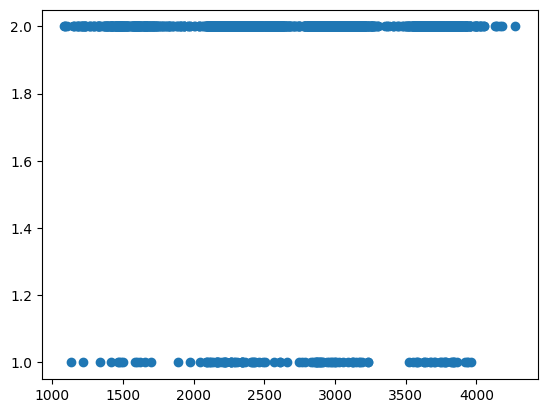

In [125]:
plt.scatter(assist['days_baseline'], assist['demo61'])